In [1]:
import matplotlib as mpl, hashlib, textwrap, re
cmap = mpl.colormaps['tab20']
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 18
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scanpy as sc, numpy as np, os
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib.patches import Patch
from utils import load_model_state, predict

In [2]:
ct, mod = "Sst", "atac" # cell type, "rna" or "atac"
feature_name = "peak" # "peak" for atac modality or "gene" for rna modality
result_dir = f"result/{ct}/{mod}/"

In [3]:
adata = sc.read_h5ad(f"adata_objects/{ct}_mgh_{mod}_v3_precomp.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 5415 × 118907
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet.filter', 'Jorstard.pred', 'harmony_clusters', 'seurat_clusters', 'remove_or_not', 'unintegrated_clusters', 'AD', 'Subclass', 'Subclass_fct', 'class', 'brain.region', 'barcode', 'nCount_ATAC', 'nFeature_ATAC', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [5]:
features_dir = os.path.join(result_dir, f"{feature_name}_importance/")

In [6]:
model_dir = os.path.join(result_dir,"models/")

### Group important scores across folds

In [16]:
feature_name = "peak"

In [24]:
result_dir = "result/astro/atac/"

In [25]:
features_dir = os.path.join(result_dir, f"{feature_name}_importance/")

In [26]:
param_df = pd.read_csv(os.path.join(result_dir,"fold_metrics.csv"))
selections = (param_df["AUROC"] > 0.7).to_list()

In [27]:
all_dfs = []
for i, keep in enumerate(selections):
    if keep:
        path = os.path.join(features_dir, f"{feature_name}_shap_importance_fold{i}.csv")
        df = pd.read_csv(path)
        df["frac_imp"] = df["Importance"] / df["Importance"].sum() * 1000
        all_dfs.append(df)

# combine them end-to-end
df_all = pd.concat(all_dfs, ignore_index=True)

# get the ranking in one go
if feature_name == "gene":
    col_name = "Gene"
elif feature_name == "peak":
    col_name = "Peak"
else:
    raise ValueError("feature name not recognized. Either peak or gene only")
ranked = (
    df_all
    .groupby(col_name)["frac_imp"]
    .mean()
    .sort_values(ascending=False)
)

In [28]:
ranked.to_csv(os.path.join(result_dir, f"common_{feature_name}_importance.csv"), index = True)

### Visualization

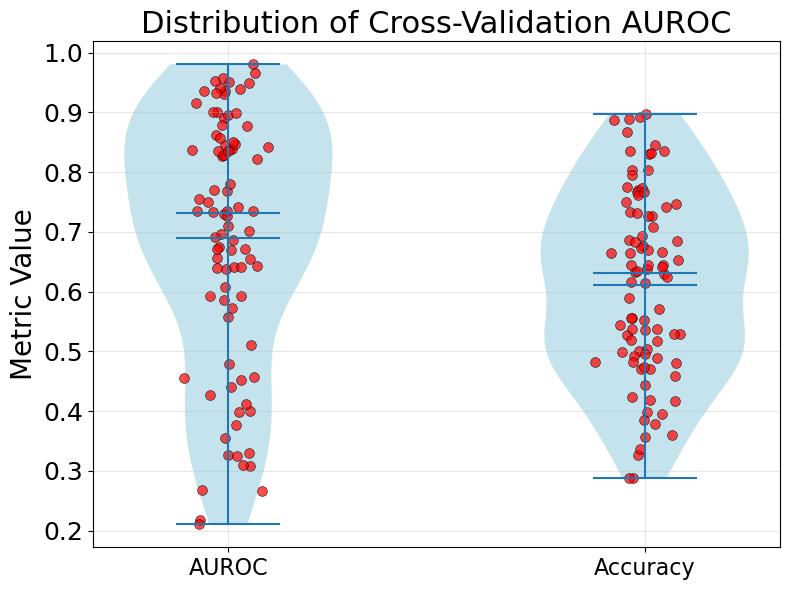

Median AUROC: 0.7318771038578205, Stdev AUROC: 0.20893779480736197
Median Accuracy: 0.6307467464013954, Stdev Accuracy: 0.15541899505865114


In [7]:
auroc_df = pd.read_csv(os.path.join(result_dir, "fold_metrics.csv"))
aucs = auroc_df['AUROC'].to_list()
accs = auroc_df['Accuracy'].to_list()
# Create violin plot
plt.figure(figsize=(8, 6))
parts = plt.violinplot([aucs, accs], showmeans=True, showmedians=True)

# Customize the violin plot
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

# Add scatter plots for individual data points
x_jitter = np.random.normal(1, 0.04, len(aucs))
x2 = np.random.normal(2, 0.04, len(accs))
plt.scatter(x_jitter, aucs, alpha=0.7, s=50, color='red', edgecolors='black', linewidth=0.5)
plt.scatter(x2, accs, alpha=0.7, s=50, color='red', edgecolors='black', linewidth=0.5)
plt.ylabel('Metric Value')
plt.title('Distribution of Cross-Validation AUROC')
plt.grid(True, alpha=0.3)
plt.xticks([1,2],["AUROC", "Accuracy"])
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print(f"Median AUROC: {np.median(aucs)}, Stdev AUROC: {np.std(aucs)}")
print(f"Median Accuracy: {np.median(accs)}, Stdev Accuracy: {np.std(accs)}")

**Donor correlation with metrics**

In [8]:
df = pd.read_csv(os.path.join(result_dir,"fold_metrics.csv"))

In [9]:
use_metric = 'AUROC'

In [10]:
df['ids'] = df['test_pair'].str.strip('[]').str.split(', ')
df_exploded = df.explode('ids')

# mean, SD, n per id
stats = (df_exploded.groupby('ids')[use_metric]
         .agg(mean='mean', sd='std', n='count')
         .reset_index())

# standard error; fill NaN (n=1) with 0 so bars plot cleanly
stats['sem'] = (stats['sd'] / np.sqrt(stats['n'])).fillna(0)

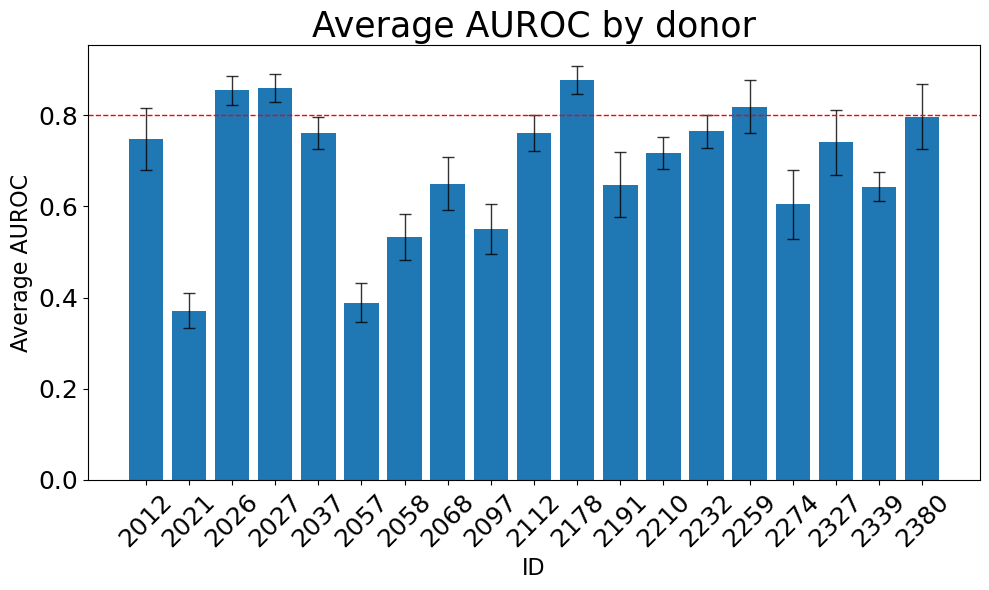

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(stats['ids'], stats['mean'],
       yerr=stats['sem'], capsize=4,
       error_kw={'elinewidth':1, 'alpha':0.8})

ax.set_xlabel('ID', fontsize = 16)
ax.set_ylabel('Average AUROC', fontsize = 16)
ax.set_title('Average AUROC by donor', fontsize = 25)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelrotation=45)  # or 30/60/90

# red dashed reference line (your code used 0.8)
ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

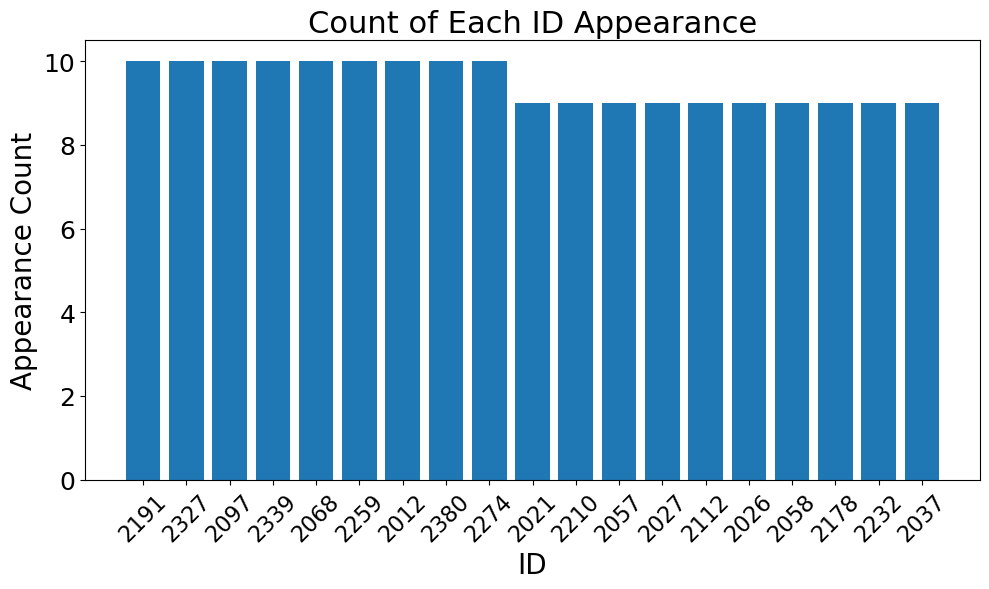

In [12]:
counts = df_exploded['ids'].value_counts().reset_index()
counts.columns = ['ID', 'Count']

# Plot as a barplot
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(counts['ID'], counts['Count'])
ax.set_xlabel('ID')
ax.set_ylabel('Appearance Count')
ax.set_title('Count of Each ID Appearance')
ax.tick_params(axis='x', labelrotation=45)  # or 30/60/90
plt.tight_layout()
plt.show()

**Predict donor-level labels**

In [13]:
adata

AnnData object with n_obs × n_vars = 5415 × 118907
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet.filter', 'Jorstard.pred', 'harmony_clusters', 'seurat_clusters', 'remove_or_not', 'unintegrated_clusters', 'AD', 'Subclass', 'Subclass_fct', 'class', 'brain.region', 'barcode', 'nCount_ATAC', 'nFeature_ATAC', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [14]:
auroc_df = pd.read_csv(os.path.join(result_dir,"fold_metrics.csv"))

In [15]:
auroc_df.head()

,Fold,test_pair,AUROC,Accuracy,threshold
0,0,"[2210, 2191]",0.656170,0.628877,0.399478
1,1,"[2021, 2191]",0.325808,0.499157,0.569827
2,2,"[2112, 2097]",0.592246,0.470000,0.461551
3,3,"[2027, 2327]",0.935756,0.733333,0.536210
4,4,"[2057, 2012]",0.451992,0.397959,0.507925


In [16]:
model_paths = os.listdir(model_dir)
def fold_num(name: str) -> int:
    return int(re.search(r"fold(\d+)_", name).group(1))

mp_sorted = sorted(model_paths, key=fold_num)

In [17]:
# PyTorch model loading
models = [load_model_state(model_dir + mp, input_dim = adata.obsm["X_pca"].shape[1]) for mp in mp_sorted]

In [18]:
len(models)

90

**PyTorch donor label prediction**

In [19]:
def hard_labels_and_median_proba(adata, auroc_df, models, obsm_key="X_pca", donor_col="orig.ident"):
    X = adata.obsm[obsm_key]
    donors = adata.obs[donor_col].to_numpy()

    # parse per-fold pairs and thresholds
    pairs = (
        auroc_df["test_pair"]
        .astype(str)
        .str.extract(r"\[\s*(-?\d+)\s*,\s*(-?\d+)\s*\]")
        .astype(int)
        .to_numpy()  # (n_folds, 2)
    )
    folds = auroc_df["Fold"].to_numpy(int)
    thr_map = dict(zip(folds, auroc_df["threshold"].astype(float)))

    # donor -> folds containing that donor
    d2f = defaultdict(list)
    for f, (a, b) in zip(folds, pairs):
        d2f[a].append(f); d2f[b].append(f)

    y_out    = np.zeros(X.shape[0], dtype=np.uint8)       # final hard labels
    pmed_out = np.full(X.shape[0], np.nan, dtype=float)   # median probs

    for d in pd.unique(donors):
        idx = np.flatnonzero(donors == d)
        fs  = d2f.get(d, [])
        if not fs or idx.size == 0:
            continue

        # probs from each relevant model for this donor's cells
        P = np.column_stack([predict(models[f], X[idx]).squeeze() for f in fs])  # (cells_donor, n_models)
        p_med = np.median(P, axis=1)
        pmed_out[idx] = p_med

        # per-model hard calls using each model's own threshold
        B = np.column_stack([(P[:, j] >= thr_map[fs[j]]).astype(np.uint8) for j in range(len(fs))])
        y_out[idx] = (B.mean(axis=1) >= 0.5).astype(np.uint8)  # majority vote

    return y_out, pmed_out  # (N,), (N,)

In [20]:
cell_labels, avg_proba = hard_labels_and_median_proba(adata, auroc_df, models, "X_pca", "orig.ident")

In [21]:
cell_labels

array([0, 0, 1, ..., 0, 0, 1], shape=(5415,), dtype=uint8)

In [22]:
avg_proba

array([0.29627454, 0.31748611, 0.82474518, ..., 0.14603215, 0.33692828,
       0.76352406], shape=(5415,))

In [23]:
# Median cell proba to predict donor label prediction
donor_pred = (
    pd.DataFrame({"orig.ident": adata.obs["orig.ident"].values, "p": avg_proba})
    .groupby("orig.ident")["p"].median()
    .gt(0.5).astype(int)
)

# donor-level ground truth (0=Control, 1=AD)
label_map = {"Control": 0, "AD": 1}
donor_true = (
    adata.obs.groupby("orig.ident")["AD"].first().map(label_map).astype(int)
)

# accuracy
acc = (donor_true.to_numpy() == donor_pred.to_numpy()).mean()
print(acc)

0.631578947368421


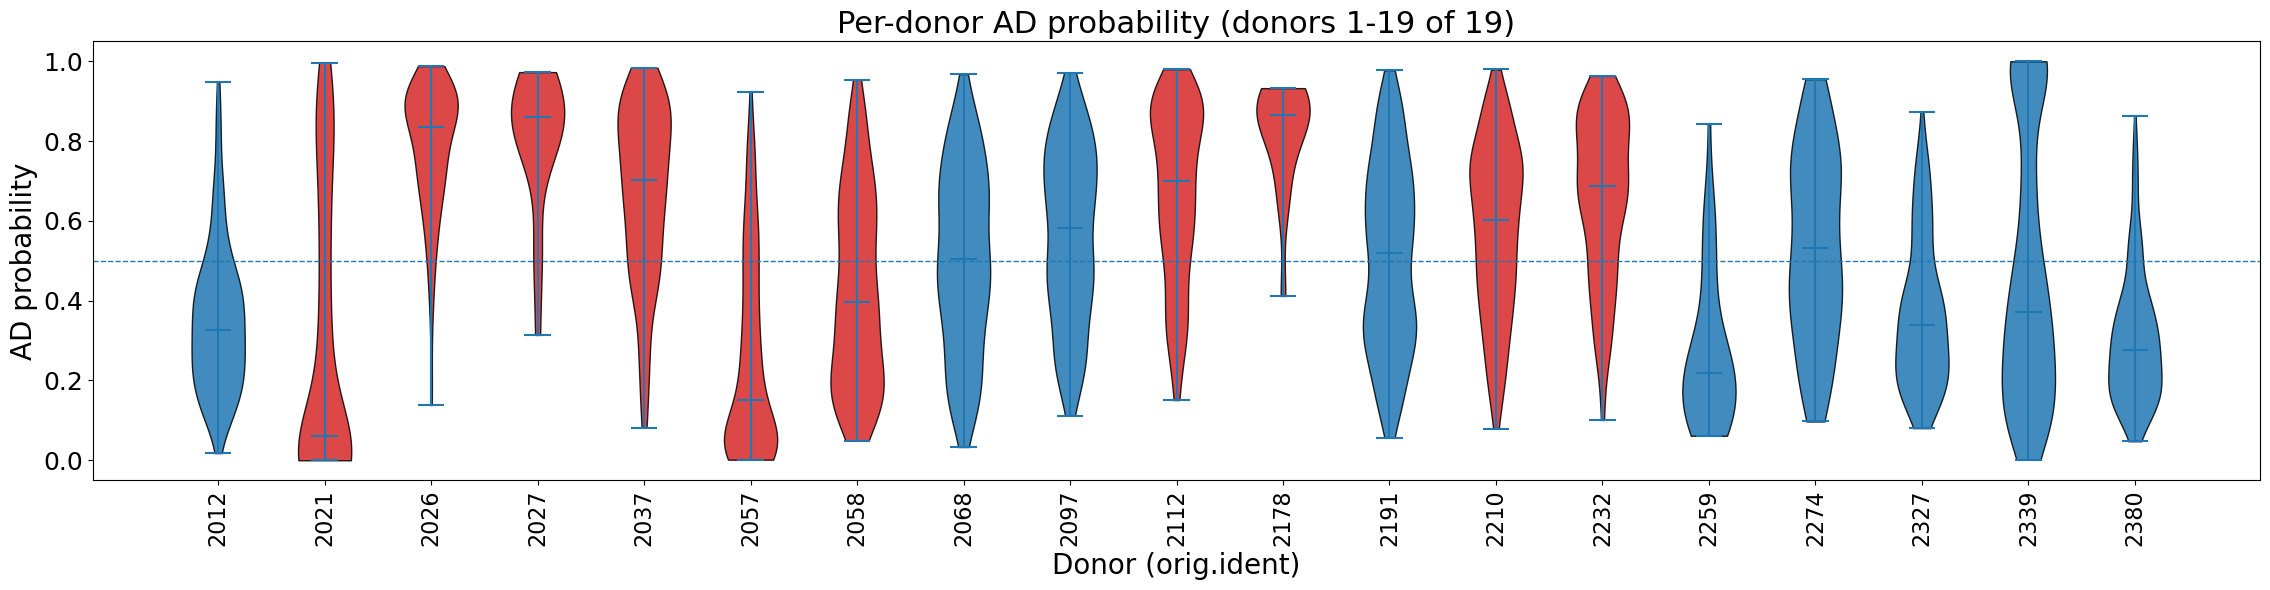

In [24]:
status = (pd.DataFrame({"donor": np.asarray(adata.obs["orig.ident"]),
                        "diag":  adata.obs["AD"].astype(str)})
          .drop_duplicates("donor"))
is_ad = status.set_index("donor")["diag"].str.contains("AD", case=False, regex=True).to_dict()

df = pd.DataFrame({"donor": adata.obs["orig.ident"], "p": avg_proba})
donors = sorted(df['donor'].unique())
per_plot = 20
for i in range(0, len(donors), per_plot):
    dn = donors[i:i+per_plot]
    groups = [df.loc[df.donor == d, "p"].values for d in dn]
    colors = ["tab:red" if is_ad.get(d, False) else "tab:blue" for d in dn]

    fig, ax = plt.subplots(figsize=(max(12, 1.2*len(dn)), 6))
    parts = ax.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)
    for b, c in zip(parts["bodies"], colors):
        b.set_facecolor(c); b.set_edgecolor("black"); b.set_alpha(0.85)

    ax.set_xticks(np.arange(1, len(dn)+1)); ax.set_xticklabels([str(d) for d in dn], rotation=90)
    ax.set_ylabel("AD probability", ); ax.set_xlabel("Donor (orig.ident)")
    ax.set_title(f"Per-donor AD probability (donors {i+1}-{i+len(dn)} of {len(donors)})")
    ax.axhline(0.5, ls="--", lw=1)
    plt.tight_layout()
    os.makedirs(os.path.join(result_dir, "donor_proba_plot"), exist_ok = True)
    plt.savefig(os.path.join(result_dir, f"donor_proba_plot/donor_proba_{i+1}-{i+len(dn)}_of_{len(donors)}.png"))
    plt.show()

**Region specific plotting**

In [25]:
pd.crosstab(adata.obs['orig.ident'], adata.obs['brain.region'])

brain.region,BA9,BA17,BA20
orig.ident,,,
2012,114,32,72
2021,24,139,39
2026,99,0,14
2027,19,0,0
2037,126,51,25
2057,253,151,64
2058,182,93,41
2068,186,143,75
2097,219,259,50


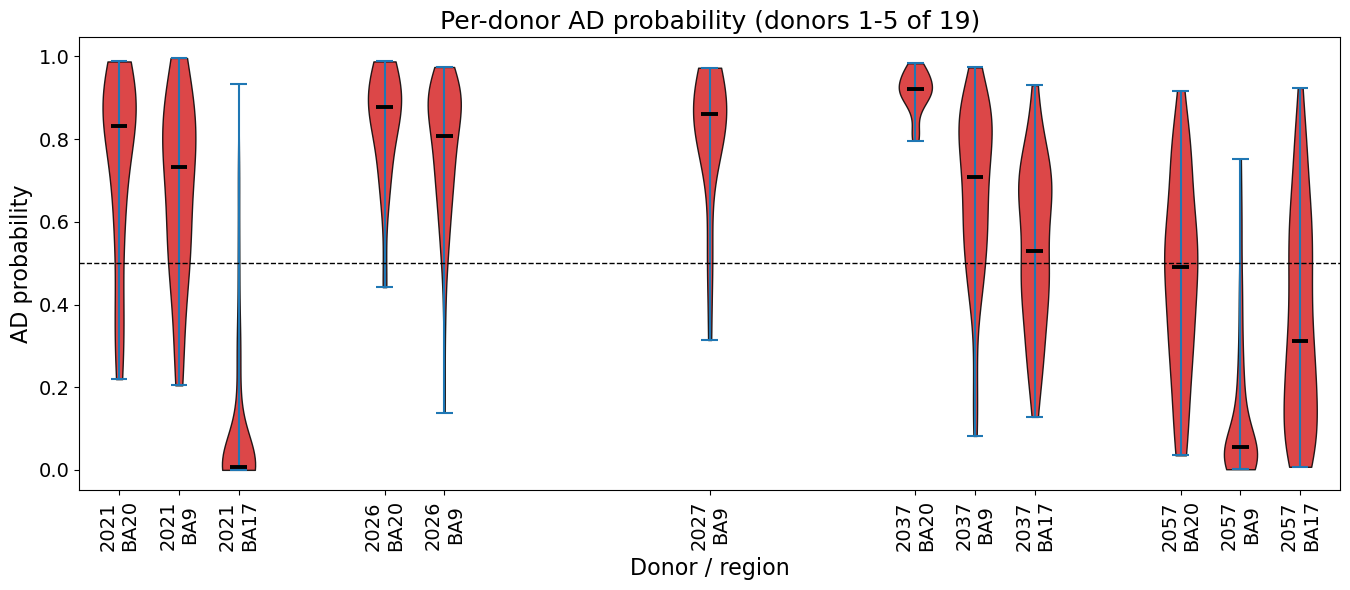

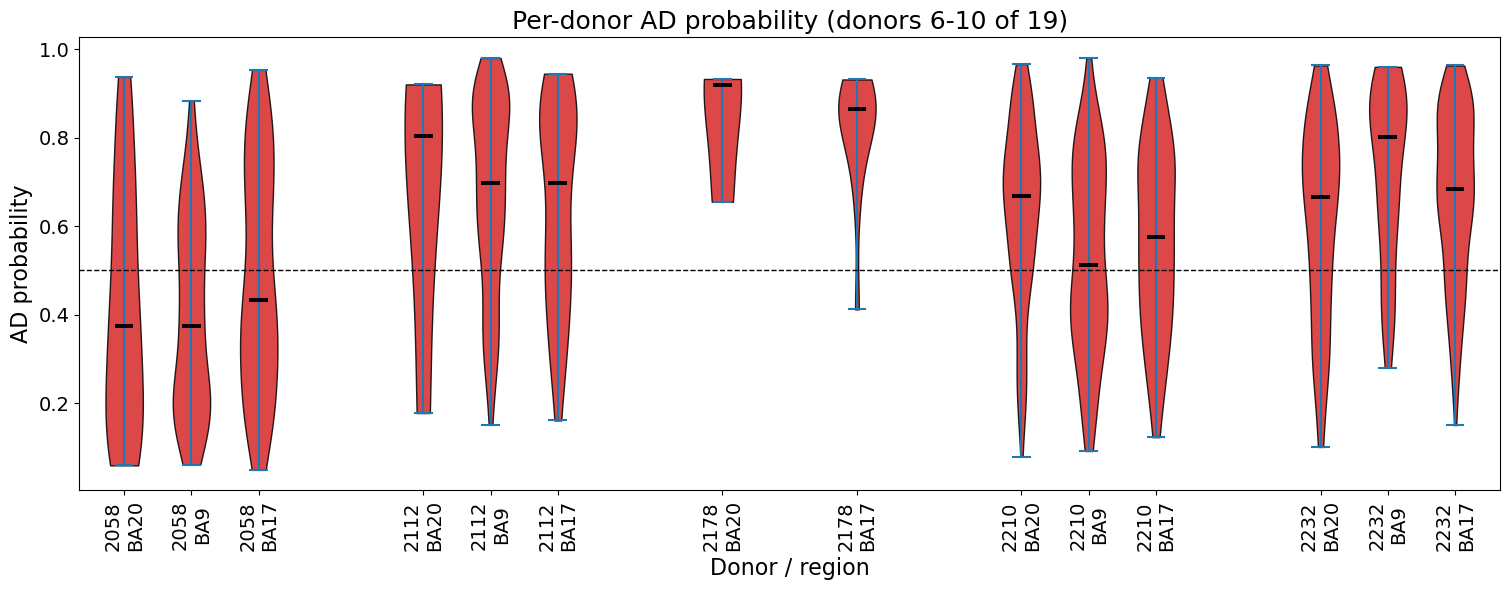

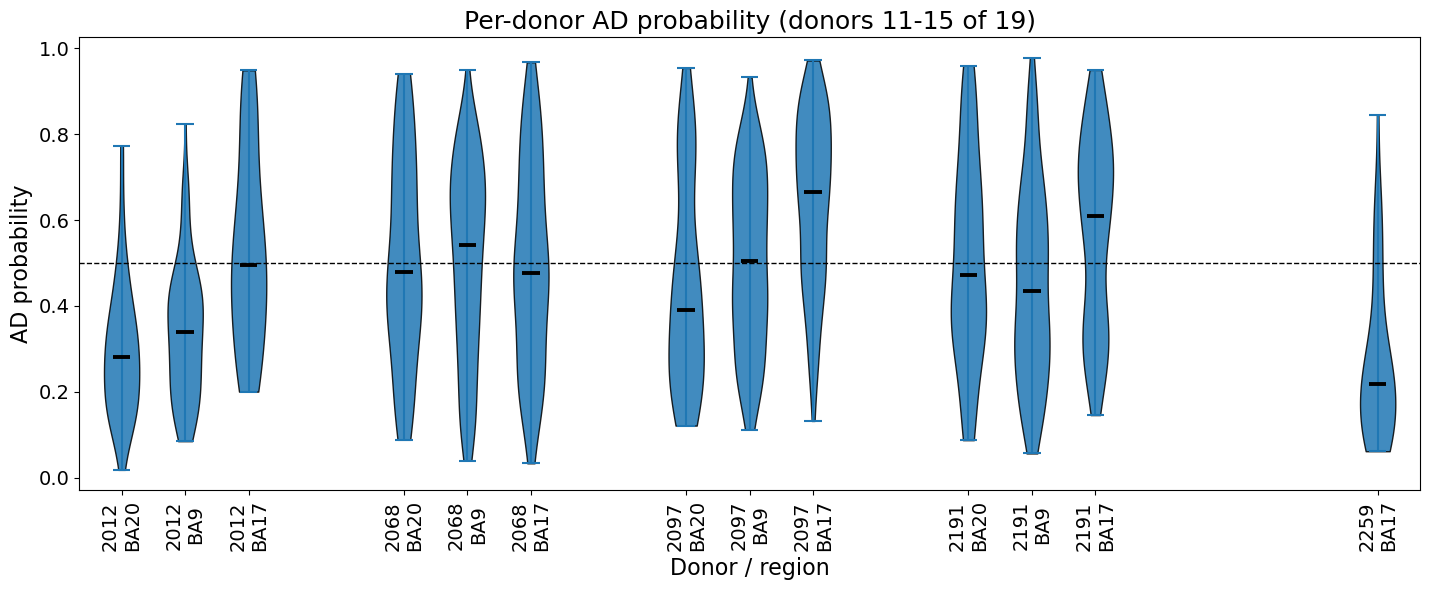

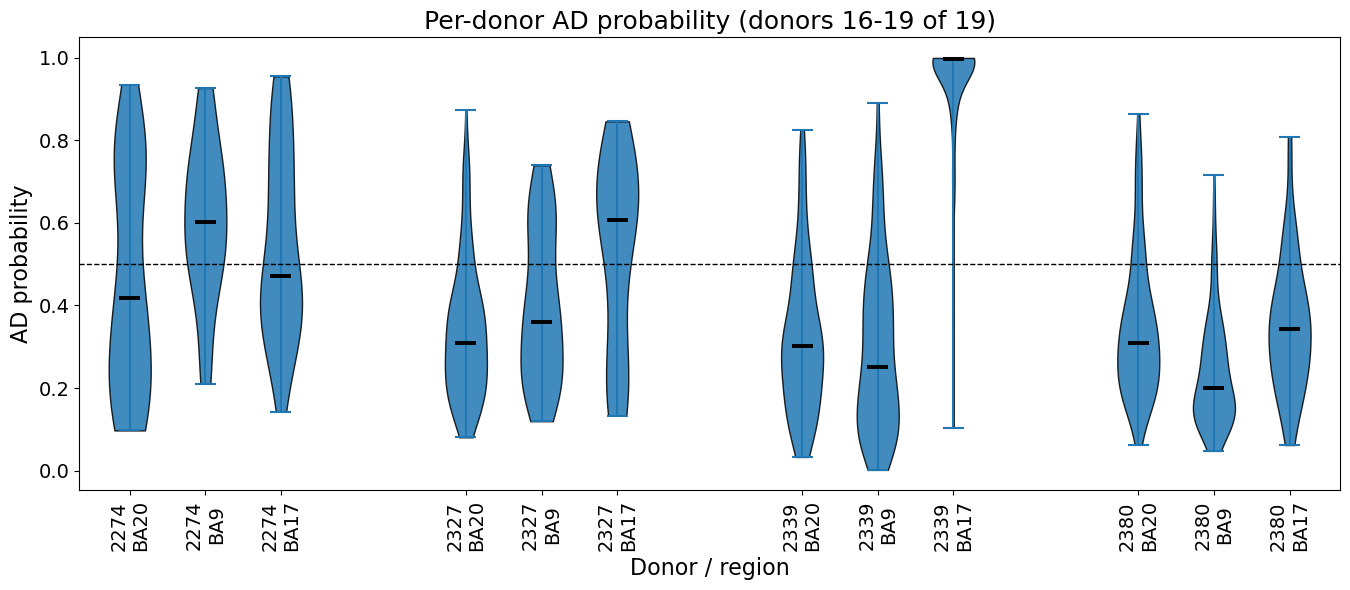

In [26]:
# assemble data
df = pd.DataFrame({
    "donor":  adata.obs["orig.ident"].to_numpy(),
    "region": adata.obs["brain.region"].astype(str).to_numpy(),
    "p":      avg_proba
})
status = (pd.DataFrame({"donor": df["donor"], "diag": adata.obs["AD"].astype(str)})
          .drop_duplicates("donor"))
# is_ad = status.set_index("donor")["diag"].str.contains("A", case=False, regex=True).to_dict()
is_ad = (adata.obs["AD"].astype(str)
         .str.fullmatch(r"(?i)ad")
         .groupby(adata.obs["orig.ident"]).any()
         .to_dict())

# donors: AD on left, Control on right
donors = sorted(df["donor"].unique())
donors = sorted(donors, key=lambda d: (not is_ad.get(d, False), d))

region_order = ["BA20","BA9","BA17"]
per_plot = 5

# fonts: >= default + 4
plt.rcParams.update({'xtick.labelsize':14, 'ytick.labelsize':14, 'axes.labelsize':16, 'axes.titlesize':18})

for i in range(0, len(donors), per_plot):
    dn = donors[i:i+per_plot]
    pos, groups, colors, labels = [], [], [], []
    for j, d in enumerate(dn):
        base = j * 4.0  # big gap between donors
        col = "tab:red" if is_ad.get(d, False) else "tab:blue"
        for k, r in enumerate(region_order):  # tight triplet per donor
            vals = df.loc[(df.donor==d)&(df.region==r), "p"].values
            if vals.size == 0: continue
            pos.append(base + k*0.9)
            groups.append(vals)
            colors.append(col)
            labels.append(f"{d}\n{r}")

    fig, ax = plt.subplots(figsize=(max(12, 0.8*len(pos)+4), 6))
    parts = ax.violinplot(groups, positions=pos, showmeans=False, showmedians=True, showextrema=True)
    for b, c in zip(parts["bodies"], colors):
        b.set_facecolor(c); b.set_edgecolor("black"); b.set_alpha(0.85)
    parts["cmedians"].set_color("black"); parts["cmedians"].set_linewidth(2.8)  # thicker median

    ax.set_xticks(pos); ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel("AD probability"); ax.set_xlabel("Donor / region")
    ax.set_title(f"Per-donor AD probability (donors {i+1}-{i+len(dn)} of {len(donors)})")
    ax.axhline(0.5, ls="--", lw=1, color="k")
    ax.set_xlim(min(pos)-0.6, max(pos)+0.6); ax.margins(x=0.01)

    plt.tight_layout()
    outdir = os.path.join(result_dir, "donor_proba_plot"); os.makedirs(outdir, exist_ok=True)
    plt.savefig(os.path.join(outdir, f"donor_proba_region_{i+1}-{i+len(dn)}_of_{len(donors)}.png"), dpi=300)
    plt.show()

### Region specific classification (based on V2)

In [4]:
df = pd.read_csv("result/DEG_DNN_v2_region/fold_auroc_by_region.csv")
df_bulk = pd.read_csv("result/DEG_DNN_v2/fold_auroc.csv")

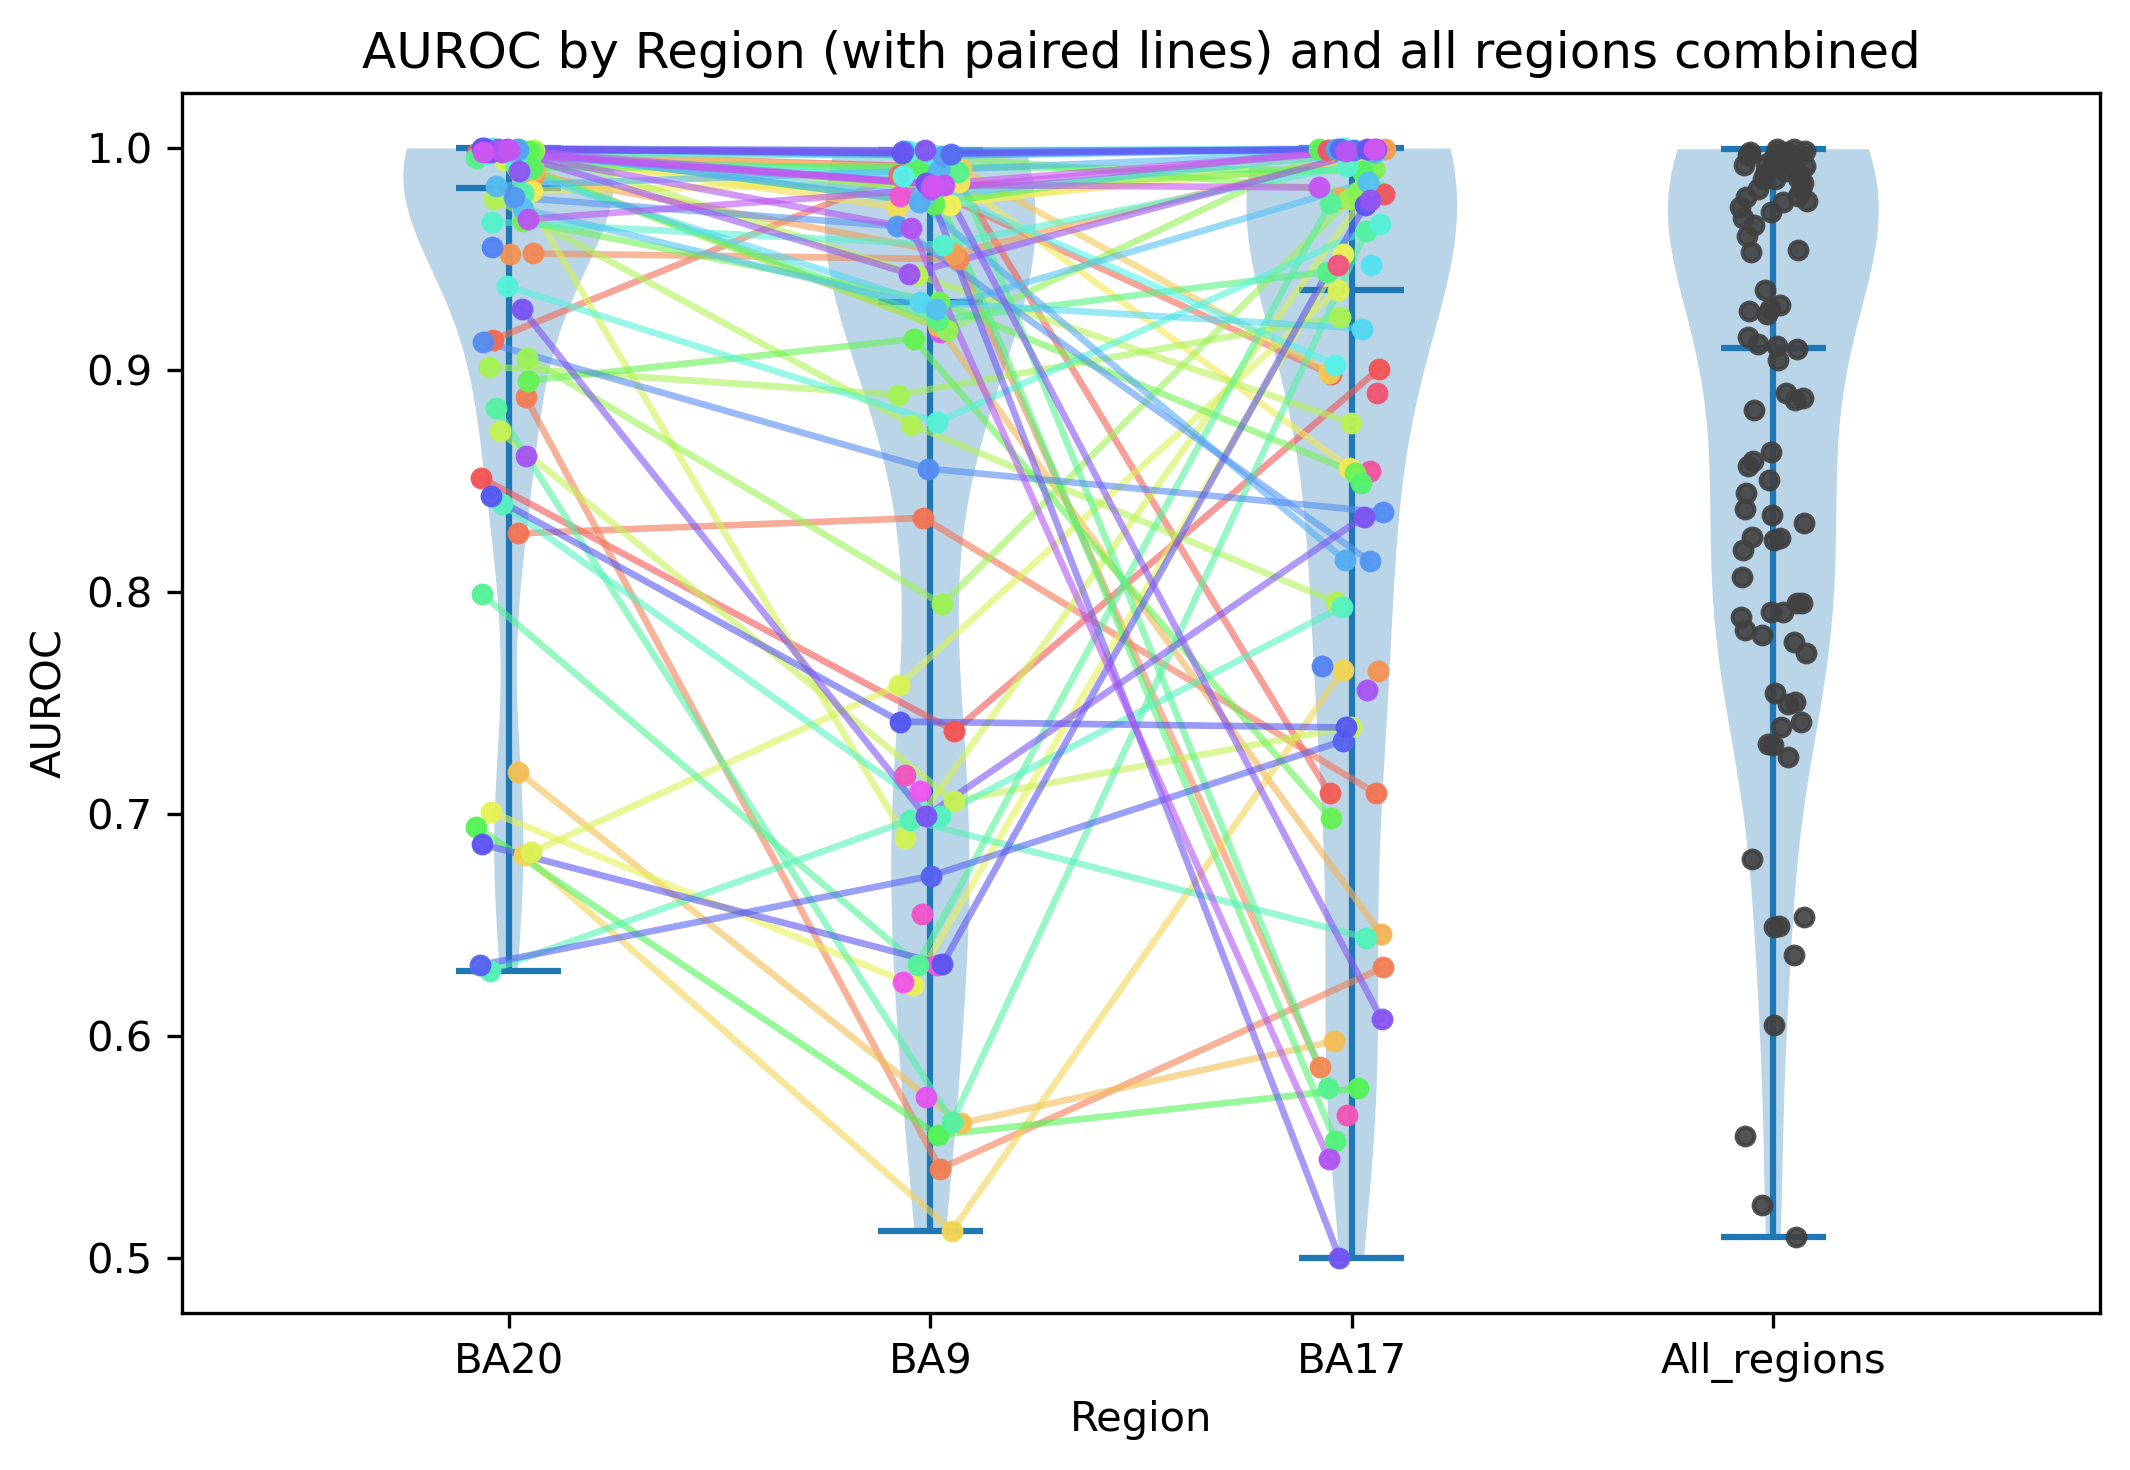

In [9]:
order = ['BA20', 'BA9', 'BA17', 'All_regions']  # add Bulk as a 4th group
# cols  = {'BA20': 'AUROC_BA20', 'BA9': 'AUROC_BA9', 'BA17': 'AUROC_BA17'}
cols  = {'BA20': 'BA20', 'BA9': 'BA9', 'BA17': 'BA17'}
pos   = {name: i for i, name in enumerate(order)}  # x positions

# --- violin data (per group) ---
data_regions = [df[cols[name]].dropna().values for name in ['BA20', 'BA9', 'BA17']]
data_bulk    = [df_bulk['AUROC'].dropna().values]
data         = data_regions + data_bulk  # order: BA20, BA9, BA17, Bulk

fig, ax = plt.subplots(figsize=(7.2, 5), dpi=300)

# 1) Violin plots (4 side-by-side)
parts = ax.violinplot(
    data,
    positions=[pos[n] for n in order],
    showextrema=True, showmedians=True
)
for pc in parts['bodies']:
    pc.set_alpha(0.30)  # faint fill

# --- deterministic, UNIQUE color per row for df (the 3 regions only) ---
# build union of indices that appear at least once in the 3 region columns, preserving order
idx_union = pd.Index(
    np.concatenate([df[c].dropna().index.values for c in cols.values()])
).unique().tolist()
n_rows = len(idx_union)

# evenly spaced hues around the HSV wheel (unique, non-repeating across these rows)
hues = np.linspace(0.0, 1.0, max(n_rows, 1), endpoint=False)
base_rgb = {
    idx: mpl.colors.hsv_to_rgb((h, 0.65, 0.95))  # (hue, saturation, value)
    for idx, h in zip(idx_union, hues)
}

def color_for(idx, alpha=1.0):
    r, g, b = base_rgb[idx]
    return (r, g, b, alpha)

# deterministic jitter so lines hit the dots
def jitter(idx, key, scale=0.08):
    h = hashlib.blake2b(f"{idx}|{key}".encode(), digest_size=8).digest()
    u = int.from_bytes(h, 'little') / 2**64  # [0,1)
    return (u - 0.5) * 2 * scale             # [-scale, +scale]

# 2) Scatter points for the 3 regions (colored per-row)
for name in ['BA20', 'BA9', 'BA17']:
    key = cols[name]
    s = df[key].dropna()
    for idx, y in s.items():
        x = pos[name] + jitter(idx, key)
        ax.scatter(x, y, s=18, color=color_for(idx, alpha=0.95), zorder=3)

# 3) Connecting lines only for rows with all three valid entries (same color)
triples = df[[cols['BA20'], cols['BA9'], cols['BA17']]].dropna()
for idx, row in triples.iterrows():
    xs = [
        pos['BA20'] + jitter(idx, cols['BA20']),
        pos['BA9']  + jitter(idx, cols['BA9']),
        pos['BA17'] + jitter(idx, cols['BA17'])
    ]
    ys = [row[cols['BA20']], row[cols['BA9']], row[cols['BA17']]]
    ax.plot(xs, ys, linewidth=1.6, color=color_for(idx, alpha=0.6), zorder=2)  # slightly thicker

# 4) Scatter points for Bulk (neutral color, no lines)
bulk_key = 'AUROC_BULK'  # just a unique tag for jitter seeding
s_bulk = df_bulk['AUROC'].dropna()
for idx, y in s_bulk.items():
    x = pos['All_regions'] + jitter(idx, bulk_key)
    ax.scatter(x, y, s=18, color=(0.25, 0.25, 0.25, 0.9), zorder=3)  # neutral gray

# cosmetics
ax.set_xticks([pos[n] for n in order])
ax.set_xticklabels(order)
ax.set_xlabel('Region')
ax.set_ylabel('AUROC')
ax.set_title('AUROC by Region (with paired lines) and all regions combined')
ax.margins(x=0.15)
plt.tight_layout()
plt.show()

## Determine the cutoff percentage of genes

**Importance score based cutoff**

In [70]:
imp_df = pd.read_csv(os.path.join(result_dir, "common_genes_importance.csv"))

In [71]:
imp_df.head()

,Peak,frac_imp
0,chr1-16913821-16914320,0.087010
1,chr10-132537302-132537801,0.076784
2,chr4-37686273-37686772,0.066093
3,chr11-44565157-44565656,0.061188
4,chr9-93095805-93096304,0.059871


In [72]:
imp_df.shape

(143709, 2)

In [73]:
imp = imp_df['frac_imp']
last = imp.shape[0] - 1

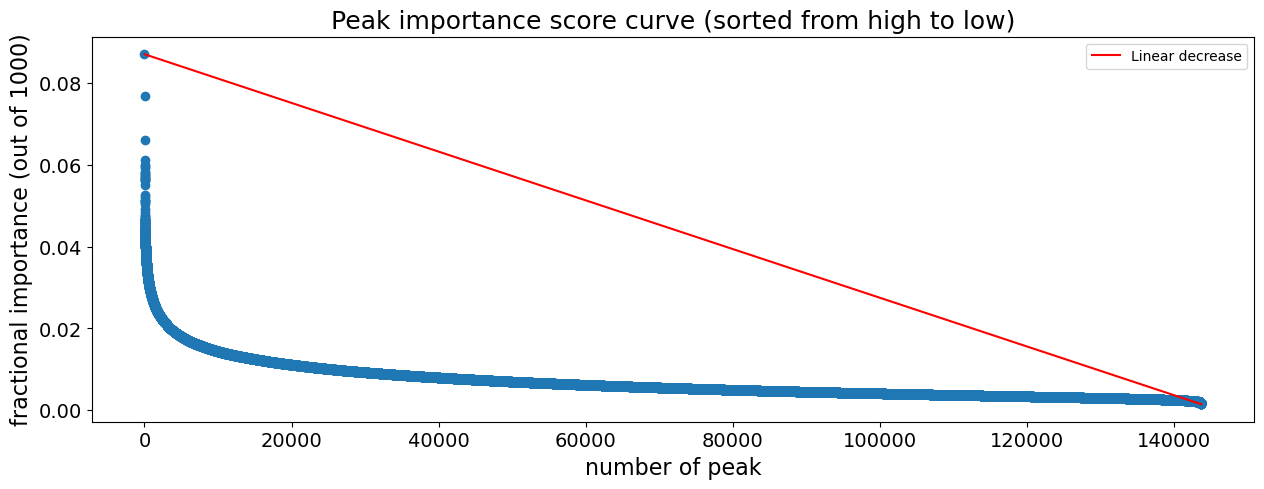

In [75]:
plt.figure(figsize = (15,5))
xvals = np.arange(imp.shape[0])
plt.title(f"{col_name} importance score curve (sorted from high to low)")
plt.xlabel(f"number of {feature_name}")
plt.ylabel("fractional importance (out of 1000)")
plt.scatter(xvals, imp)
plt.plot([0,last], [imp[0], imp[last]], label = "Linear decrease", color = "red")
plt.legend()

In [76]:
def elbow_cutoff_distance(imp):
    y = np.asarray(imp, float)
    y = np.sort(y)[::-1]              # rank high -> low
    n  = y.size
    x  = np.arange(n, dtype=float)

    # chord first->last
    x1, y1 = 0.0,   y[0]
    x2, y2 = n-1.0, y[-1]
    dx, dy = (x2 - x1), (y2 - y1)
    denom  = np.hypot(dx, dy)

    # perpendicular distance of each (x,y) to the chord (no np.cross)
    dist = np.abs(dy*(x - x1) - dx*(y - y1)) / denom

    idx   = int(np.argmax(dist))   # 0-based elbow index
    k_cut = idx + 1                # keep top k_cut genes
    return k_cut, idx

In [77]:
k_cut, _ = elbow_cutoff_distance(imp_df["frac_imp"])
top_genes = imp_df.sort_values("frac_imp", ascending=False).head(k_cut)
k_cut

8670

**Competitive null**

In [9]:
# 2. pull out only those genes (this makes a dense DataFrame)
df = adata.to_df()

# 3. add your grouping column
df['group'] = adata.obs['orig.ident']

# 4. aggregate counts per group (sum for total counts, mean for avg expression…)
grouped_mean   = df.groupby('group').mean().T  # average expression per group, genes as rows

In [10]:
expr_raw = grouped_mean.mean(axis = 1)

In [16]:
imp_raw = imp_df.set_index("Gene")["frac_imp"].astype(float)
common = expr_raw.index.intersection(imp_raw.index)

# aligned, with imp's ranking preserved
imp  = imp_raw.loc[common]
expr = expr_raw.loc[common]

In [24]:
def block_enrich_gpu_strat_private(
    imp_df: pd.DataFrame,      # columns: ["Gene","frac_imp"], private importances (sum ~ 1000), high->low
    expr: pd.Series,           # donor-averaged expression (index=Gene), from the same private dataset
    B=20000, batch=2000, n_bins=10, block=50, kmax=5000, seed=0
):
    # ---- prep: rank by importance & make expression bins (label-agnostic) ----
    imp = imp_df.set_index("Gene")["frac_imp"].astype(float)
    expr = expr.reindex(imp.index).astype(float)
    order = np.argsort(-imp.values)                                  # high -> low
    v = cp.asarray(imp.values[order], dtype=cp.float32)              # sorted importances
    bins_pd = pd.qcut(expr.values[order], q=n_bins, labels=False, duplicates="drop")
    bins = cp.asarray(bins_pd, dtype=cp.int32)
    n_bins_eff = int(bins_pd.max()) + 1
    n = int(v.size)
    tot = float(v.sum().get())

    # keep only full 50-gene blocks up to kmax
    n_keep   = min(kmax, (n // block) * block)
    n_blocks = n_keep // block
    cp.random.seed(seed)

    # pools per expression bin
    idx_by_bin = [cp.where(bins == b)[0] for b in range(n_bins_eff)]

    # ---- per-block Monte-Carlo: expression-matched sampling ----
    P  = np.empty(n_blocks)
    NES = np.empty(n_blocks)
    mass = np.empty(n_blocks)
    for bi in range(n_blocks):
        s, e = bi * block, (bi + 1) * block
        obs_sum = float(v[s:e].sum().get())
        mass[bi] = obs_sum / tot
        cnt = cp.bincount(bins[s:e], minlength=n_bins_eff).get()     # how many from each bin in this block

        ge = 0; s1 = 0.0; s2 = 0.0; done = 0
        while done < B:
            cur = min(batch, B - done)
            total = cp.zeros(cur, dtype=cp.float32)
            for b in range(n_bins_eff):
                c = int(cnt[b])
                if c == 0: continue
                pool = idx_by_bin[b]
                # sample c without replacement per row via argpartition trick
                r = cp.random.random((cur, pool.size), dtype=cp.float32)
                sel = cp.argpartition(r, c-1, axis=1)[:, :c]
                total += v[pool][sel].sum(axis=1)
            ge += int((total >= obs_sum).sum().get())
            t = total.astype(cp.float64)
            s1 += float(t.sum().get()); s2 += float((t*t).sum().get())
            done += cur

        mu = s1 / B
        sd = max(0.0, s2 / B - mu * mu) ** 0.5
        NES[bi] = (obs_sum - mu) / (sd if sd > 0 else 1.0)
        P[bi]   = (ge + 1) / (B + 1)

    # ---- BH-FDR across blocks ----
    order_p = np.argsort(P); q = np.empty_like(P); m = len(P); run = 1.0
    for rank, j in enumerate(order_p, 1):
        run = min(run, P[j] * m / rank); q[j] = run

    df = pd.DataFrame({
        "block": np.arange(n_blocks),
        "k_end": (np.arange(n_blocks) + 1) * block,
        "block_mass": mass, "NES": NES, "p": P, "q": q
    })

    # cutoff = end of last significant block (q < 0.05); 0 if none
    sig = np.where(df["q"].values < 0.05)[0]
    k_cut = int(df["k_end"].iloc[sig.max()]) if sig.size else 0
    return df, k_cut

In [25]:
df_blocks, k_cut = block_enrich_gpu_strat_private(imp_df, expr, B=20000, batch=2000, n_bins=10, seed=0)
print("Cutoff k =", k_cut)

Cutoff k = 5000


In [34]:
df_blocks["FDR"] = false_discovery_control(df_blocks["p"])

In [35]:
df_blocks[df_blocks['FDR'] < 0.05]

,block,k_end,block_mass,NES,p,q,FDR
0,0,50,0.035817,23.603478,0.00005,0.005000,0.000625
1,1,100,0.025570,12.567020,0.00005,0.002500,0.000625
2,2,150,0.022385,9.770226,0.00005,0.001667,0.000625
3,3,200,0.020613,8.475994,0.00005,0.001250,0.000625
4,4,250,0.019446,6.939197,0.00005,0.001000,0.000625
5,5,300,0.018612,6.650843,0.00005,0.000833,0.000625
6,6,350,0.017748,5.543141,0.00005,0.000714,0.000625
7,7,400,0.017025,4.174000,0.00030,0.000625,0.003333
8,8,450,0.016304,4.733420,0.00005,0.000625,0.000625
9,9,500,0.015547,3.646811,0.00075,0.000625,0.007500


In [26]:
df_blocks.tail()

,block,k_end,block_mass,NES,p,q
95,95,4800,0.003031,-1.793676,0.974901,0.000625
96,96,4850,0.002995,-2.572190,0.998800,0.000625
97,97,4900,0.002955,-1.652007,0.963152,0.000625
98,98,4950,0.002919,-2.015379,0.988901,0.000625
99,99,5000,0.002876,-0.952783,0.831858,0.000625


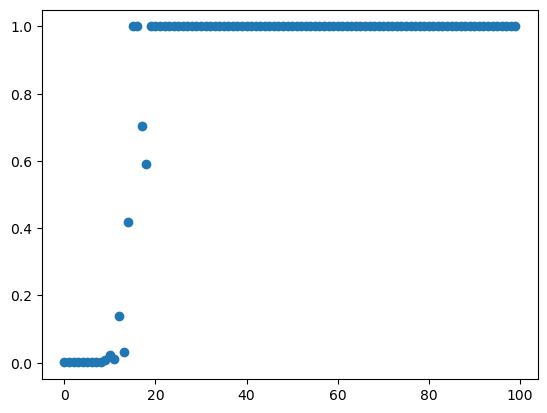

In [36]:
plt.scatter(range(df_blocks.shape[0]), df_blocks['FDR'])

**Plot out common set of genes with their logCPM** <br>
Get the intersection of top 100 genes with highest avg contribution to importance in all fold, perform GO, and plot out logCPM <br>
Folds with AUROC below 0.7 are not used

In [ ]:
top_gene_num = 80

In [ ]:
top_ranked = list(ranked.head(top_gene_num).index)

In [8]:
ranked.shape

(13964,)

In [9]:
# sc.pp.normalize_total(adata, target_sum = 1e6)

In [10]:
# 2. pull out only those genes (this makes a dense DataFrame)
df = adata[:, top_ranked].to_df()

# 3. add your grouping column
df['group'] = adata.obs['orig.ident']

# 4. aggregate counts per group (sum for total counts, mean for avg expression…)
grouped_mean   = df.groupby('group').mean()  # average expression per group

# 5. (optional) transpose if you prefer genes as rows
grouped_mean = grouped_mean.T

In [11]:
grouped_mean = grouped_mean.div(grouped_mean.sum()) * 1e6

In [12]:
grouped_mean.head()

group,2012,2021,2026,2027,2037,2057,2058,2068,2097,2112,2178,2191,2210,2232,2259,2274,2327,2339,2380
DPP10,26111.498047,24226.458984,27433.175781,37538.867188,17998.330078,32973.039062,22681.796875,40075.167969,23142.128906,13699.427734,29296.894531,28033.691406,23926.109375,31265.109375,45676.425781,33146.054688,31254.164062,30064.828125,30910.804688
MT-ND3,26300.150391,27208.919922,19307.458984,35234.777344,30254.322266,22937.453125,29726.832031,11296.333984,7386.988281,17892.642578,28078.835938,15136.565430,17014.673828,19634.335938,12700.762695,17688.736328,8917.524414,16749.968750,13735.847656
MT-ATP6,25721.125000,21859.605469,17916.646484,31434.074219,27729.976562,20248.447266,24292.494141,12576.463867,8564.593750,15427.613281,26442.050781,14442.807617,15130.161133,17343.115234,17486.917969,19670.130859,13152.679688,14908.898438,14404.364258
MT-CO2,24180.439453,21396.966797,17546.140625,29488.134766,23410.015625,23760.339844,22345.873047,12632.390625,9043.250000,14828.528320,24399.083984,13583.142578,15110.380859,15870.088867,16605.271484,17835.562500,15670.148438,16810.244141,13942.793945
LINC00499,28432.193359,18388.958984,8957.647461,8844.529297,14803.486328,10462.465820,7277.166992,10877.828125,2505.634277,18335.462891,12350.731445,9509.958984,21349.779297,7319.144043,7902.125977,10133.758789,6755.350586,5662.120605,10455.430664


In [13]:
log_mean = np.log2(grouped_mean + 1)

In [14]:
id_status = (
    adata.obs
    [['orig.ident','AD']]
    .drop_duplicates()
    .set_index('orig.ident')['AD']
)

# 2. Convert to a dict: { 'Sample1': 'AD', 'Sample2': 'Control', … }
mapping = id_status.to_dict()

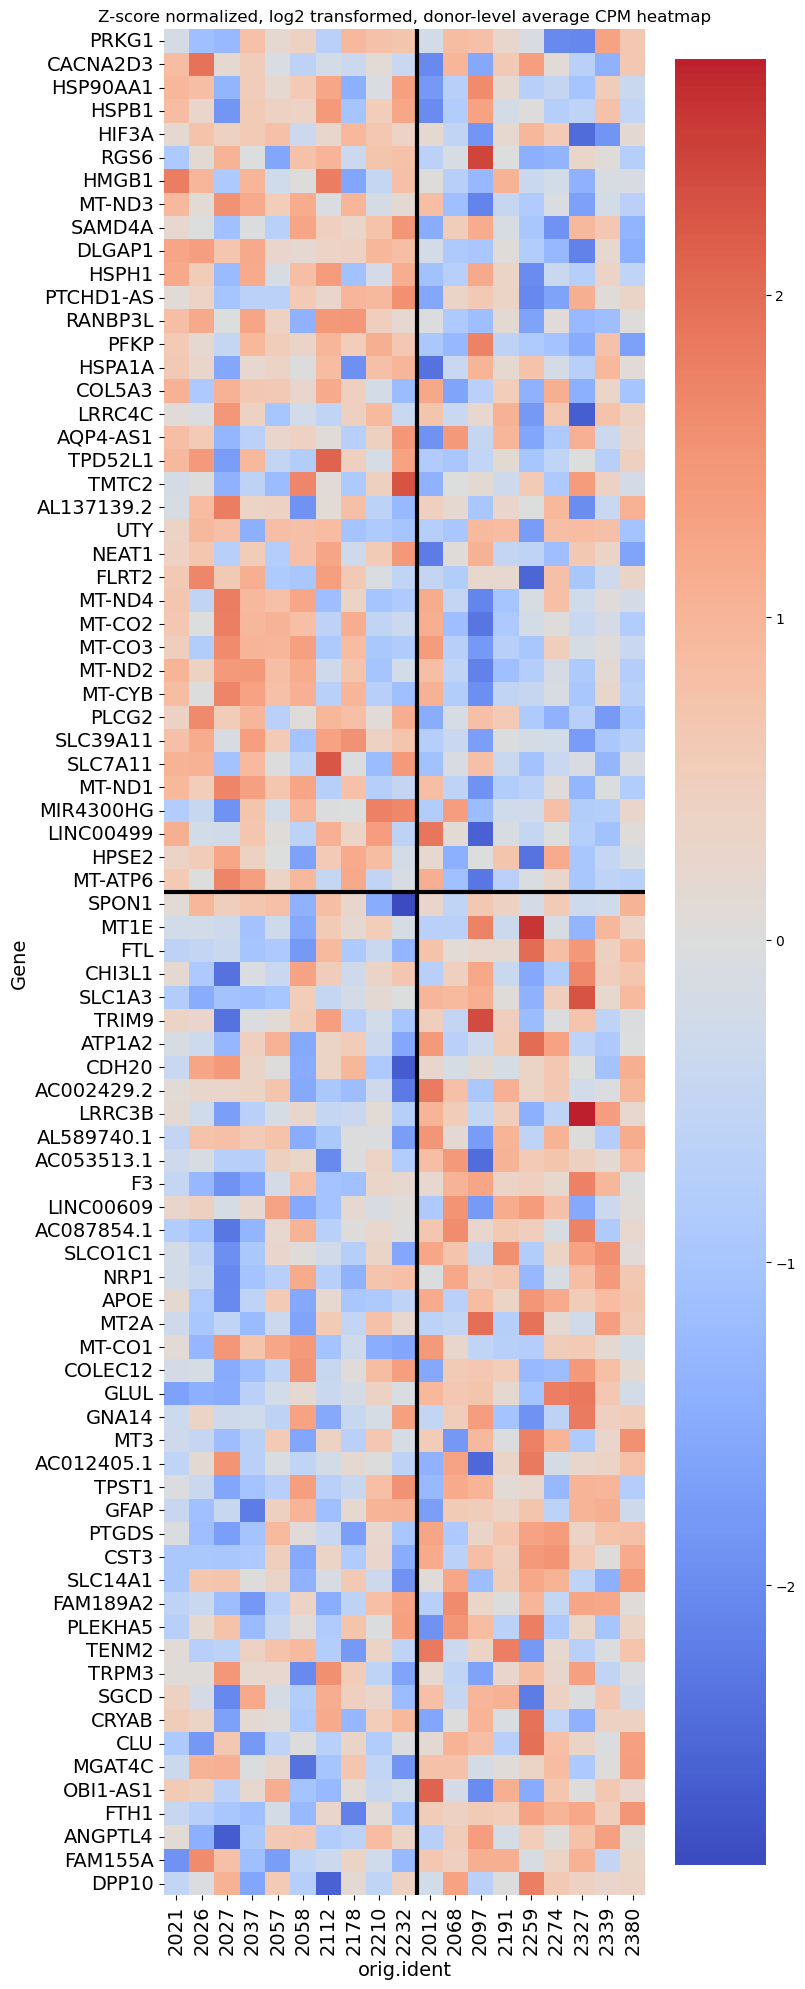

In [17]:
ad_ids   = sorted([iid for iid, st in mapping.items() if st == 'AD'])
ctrl_ids = sorted([iid for iid, st in mapping.items() if st != 'AD'])
ordered_ids = ad_ids + ctrl_ids

# 1) Reorder columns to match display order
M = log_mean.reindex(columns=ordered_ids)

# 2) Per-gene z-score across donors (rows = genes)
row_means = M.mean(axis=1)
row_stds  = M.std(axis=1).replace(0, np.nan)     # avoid divide-by-zero
Z = M.sub(row_means, axis=0).div(row_stds, axis=0).fillna(0.0)

# 3) Decide which genes are higher in AD vs Control *using the same order*
mean_AD  = Z[ad_ids].mean(axis=1)
mean_CTL = Z[ctrl_ids].mean(axis=1)
flag = mean_AD > mean_CTL                       # True = higher in AD
n_true = int(flag.sum())

# 4) Put “higher in AD” genes on top, then the rest
gene_order = flag.sort_values(ascending=False).index
Z_plot = Z.loc[gene_order, ordered_ids]

# 5) Plot with a fixed color scale so colors don’t shift with top_gene_num
fig, ax = plt.subplots(figsize=(8, 0.25*top_gene_num))
# sns.heatmap(Z_plot, ax=ax, cmap="coolwarm", center=0, vmin=-2, vmax=2)
sns.heatmap(Z_plot, ax=ax, cmap="coolwarm", center=0)

# 6) Draw clean split lines at the boundaries
# vertical: between AD and Control columns
ax.axvline(x=len(ad_ids), color="black", linewidth=3)      # boundary between col len(AD)-1 and len(AD)

# horizontal: between "higher in AD" block and the rest
ax.axhline(y=n_true, color="black", linewidth=3)           # boundary between row n_true-1 and n_true

ax.set_xlabel("orig.ident", fontsize = 14); ax.set_ylabel("Gene", fontsize = 14)
ax.set_title("Z-score normalized, log2 transformed, donor-level average CPM heatmap")
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig(f"{data_dir}DNN_v3_top{top_gene_num}_log2CPM_z_norm.png", dpi = 300)
plt.show()

**Prepare common sets of genes for downstream analysis**

In [43]:
select_count = int(1.0 * ranked.shape[0])
selected_degs = list(ranked.head(select_count).index)
pd.DataFrame({"genes": selected_degs}).to_csv(f"{data_dir}common_genes.csv", index = False)
ranked.to_csv(f"{data_dir}common_genes_importance.csv", index = True)

In [44]:
adata

AnnData object with n_obs × n_vars = 25895 × 13964
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet.filter', 'Jorstard.pred', 'harmony_clusters', 'seurat_clusters', 'remove_or_not', 'unintegrated_clusters', 'AD', 'Subclass', 'Subclass_fct', 'class', 'brain.region', 'Louvain_2', 'SLM', 'optm_clusters', 'Leiden', 'tp_mkr_1', 'tp_mkr_2', 'tp_mkr_3', 'tp_mkr_4', 'tp_mkr_5', 'tp_mkr_6', 'tp_mkr_7', 'tp_mkr_8', 'tp_mkr_9', 'tp_mkr_10', 'tp_mkr_11', 'tp_mkr_12', 'tp_mkr_13', 'tp_mkr_14', 'tp_mkr_15', 'tp_mkr_16', 'tp_mkr_17', 'tp_mkr_18', 'A1_reactive1', 'Mature_astrocyte2', 'Progenitor_marker3', 'Reactive_microglia4', 'Scar_forming5', 'Tripartite_synapse6', 'celltype', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [45]:
# adata = sc.read_h5ad("result/aci_dims1to10_06_19_25_type_anno.h5ad")

In [46]:
# sc.pp.normalize_total(adata, target_sum = 1e4)
# sc.pp.log1p(adata, base = 2)
# is_ad   = adata.obs['AD'] == 'AD'
# is_ctrl = adata.obs['AD'] == 'Control'
# X = adata.X.toarray()

In [ ]:
# is_ad   = adata.obs['AD'] == 'AD'
# is_ctrl = adata.obs['AD'] == 'Control'
# 3) Compute mean log2-expression per gene in each group
# mean_ad   = X[is_ad   .values, :].mean(axis=0)
# mean_ctrl = X[is_ctrl .values, :].mean(axis=0)

# # 4) Difference = log₂FC(AD vs Control)
# log2fc = mean_ad - mean_ctrl

In [58]:
# 5) Package as a pandas Series for easy indexing/sorting
# fc_series = pd.Series(log2fc, index=adata.var_names, name='log2FC_AD_vs_Control')
# fc_series = fc_series.sort_values(ascending=False)

# print(fc_series.head(10))

In [47]:
lut = pd.read_parquet("../donor_dict.parquet")

In [59]:
# 2. pull out only those genes (this makes a dense DataFrame)
df = adata.to_df()

# 3. add your grouping column
df['group'] = adata.obs['orig.ident']

# 4. aggregate counts per group (sum for total counts, mean for avg expression…)
grouped_mean   = df.groupby('group').mean()  # average expression per group

# 5. (optional) transpose if you prefer genes as rows
grouped_mean = grouped_mean.T
grouped_mean = grouped_mean.div(grouped_mean.sum()) * 1e6
log_mean = np.log2(grouped_mean + 1)

In [60]:
s = lut.set_index("orig.ident").loc[log_mean.columns, "AD"]  # align donors → status
m = log_mean.T.groupby(s).mean().T                 # mean of log(x+1) per status
fc_series = m["AD"] - m["Control"]                 # per-gene log2FC

In [64]:
ups, downs = list(), list()
for g in selected_degs:
    if fc_series[g] > 0:
        ups.append(g)
    elif fc_series[g] < 0:
        downs.append(g)
pd.DataFrame({"genes": ups}).to_csv(f"{data_dir}common_genes_up.csv", index = False)
pd.DataFrame({"genes": downs}).to_csv(f"{data_dir}common_genes_down.csv", index = False)

### Plot important genes in latent space

In [17]:
adata = sc.read_h5ad("result/aci_dims1to10_06_19_25_type_anno.h5ad")

In [18]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [19]:
comm_genes = pd.read_csv(f"{data_dir}common_genes.csv")["genes"].to_list()

In [20]:
comm_genes = comm_genes[:int(0.01 * len(comm_genes))]

In [21]:
len(comm_genes)

139

In [22]:
df = adata[:, comm_genes].to_df()
df['group'] = adata.obs['orig.ident']
grouped_mean   = df.groupby('group').mean()

In [23]:
grouped_mean.head()

,DPP10,MT-ND3,MT-ATP6,MT-CO2,LINC00499,PLCG2,MT-CO3,HPSE2,MIR4300HG,MT2A,...,PTPN13,MED12L,LINC01088,MRAS,MAST4,ARHGAP26,NCAM2,DLG2,GLIS3,SIK3
group,,,,,,,,,,,,,,,,,,,,,
2012,2.447955,2.465075,2.410740,2.266361,2.665278,0.745900,2.244309,1.184104,0.680626,0.784839,...,0.627093,1.042848,0.080789,0.383018,1.198906,0.844887,1.767994,1.659688,1.489043,1.219191
2021,2.853066,3.204109,2.574004,2.519524,2.165519,2.001756,2.210283,1.602883,0.845491,1.125664,...,1.024816,1.444834,0.328645,0.835146,1.538770,1.800890,2.321722,1.900963,2.435910,1.388379
2026,3.014760,2.121510,1.968656,1.927944,0.984276,3.091267,1.437915,1.660933,0.933676,0.803993,...,1.339463,1.845381,0.646168,0.743596,1.836075,2.377597,2.811139,2.151064,2.566458,1.609423
2027,3.561020,3.342171,2.981589,2.796912,0.838844,1.718060,2.440282,1.996617,0.429919,0.814795,...,0.658940,1.334682,0.876755,0.565729,1.040080,1.288987,2.442224,1.672513,1.582320,1.157172
2037,2.063901,3.469251,3.179713,2.684236,1.697408,2.478908,2.478748,1.616718,1.560411,0.754844,...,0.984680,1.496306,0.436796,1.134494,1.513279,1.880815,2.317532,1.844651,2.542901,1.353640


In [ ]:
n_pcs = 5
pca = PCA(n_components = n_pcs)
pcs = pca.fit_transform(grouped_mean)

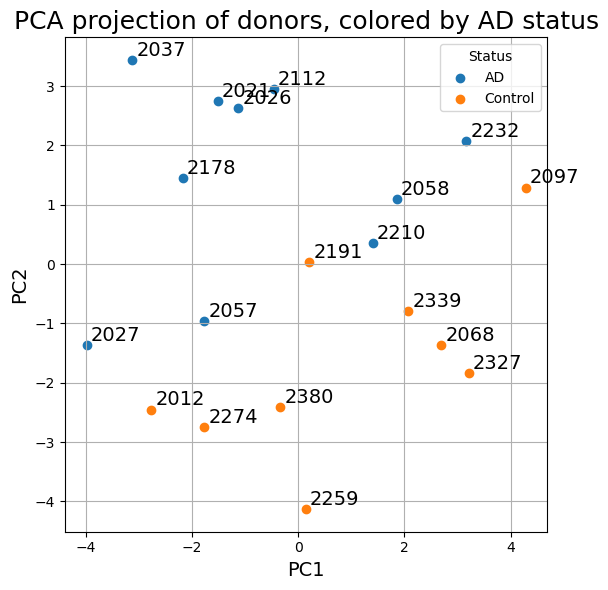

In [37]:
pc_plt_1, pc_plt_2 = 'PC1', 'PC2'

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(n_pcs)], index = grouped_mean.index)
status_per_donor = (
    adata.obs
         .groupby('orig.ident')['AD']
         .first()                   # or .mode()[0] if you want the most common
)
df_pca['Status'] = df_pca.index.map(status_per_donor)

fig, ax = plt.subplots(figsize = (6,6))
for status, sub in df_pca.groupby('Status', observed = False):
    ax.scatter(sub[pc_plt_1], sub[pc_plt_2], label=status)
for idx, row in df_pca.iterrows():
    ax.annotate(
        idx,                             # the text to display
        xy=(row[pc_plt_1], row[pc_plt_2]),     # point to label
        xytext=(3, 3),                   # offset text by 3 pts right & up
        textcoords='offset points',      
        fontsize=14                       # shrink font if many labels
    )
ax.set_xlabel(pc_plt_1, fontsize = 14)
ax.set_ylabel(pc_plt_2, fontsize = 14)
ax.set_title('PCA projection of donors, colored by AD status', fontsize = 18)
ax.legend(title='Status')
plt.grid()
plt.tight_layout()
plt.show()

(1,4), (2,4), (2,5) when frac = 0.01 <br>
(2,4), (3,4) when frac = 0.2
(2,5) when frac = 0.005 <br>

Run 2
(2,3) when frac = 0.005
(2,3) when frac = 0.01

### Compare with Bing Yang's result

In [48]:
xgb_up_df = pd.read_csv("result/DEG_cross_validation_v5_run1/common_genes_up.csv")
xgb_down_df = pd.read_csv("result/DEG_cross_validation_v5_run1/common_genes_down.csv")
dnn_up_df = pd.read_csv("result/DEG_DNN_v2/common_genes_up.csv")
dnn_down_df = pd.read_csv("result/DEG_DNN_v2/common_genes_down.csv")

In [49]:
xgboost_up_top = xgb_up_df.head(int(0.2 * xgb_up_df.shape[0]))
xgboost_down_top = xgb_down_df.head(int(0.2 * xgb_down_df.shape[0]))
dnn_up_top = dnn_up_df.head(int(0.02 * dnn_up_df.shape[0]))
dnn_down_top = dnn_down_df.head(int(0.02 * dnn_down_df.shape[0]))

In [50]:
xgboost_up_genes = xgboost_up_top["genes"].to_list()
xgboost_down_genes = xgboost_down_top["genes"].to_list()
dnn_up_genes = dnn_up_top["genes"].to_list()
dnn_down_genes = dnn_down_top["genes"].to_list()

In [51]:
edger_up_genes = pd.read_csv("result/DEG_Bing_Yang/up_genes.txt", header = None)[0].to_list()
edger_down_genes = pd.read_csv("result/DEG_Bing_Yang/down_genes.txt", header = None)[0].to_list()

In [52]:
def venn3_counts(a, b, c, title="",
                 labels=("A","B","C"), unweighted=True, show_zero=True):
    A, B, C = set(a), set(b), set(c)

    # format: numbers only; optionally hide zeros
    fmt = (lambda x: f"{int(x)}") if show_zero else (lambda x: "" if (x is None or x == 0) else f"{int(x)}")

    kwargs = dict(set_labels=labels, subset_label_formatter=fmt)
    if unweighted:  # force three visible, same-sized circles
        kwargs["layout_algorithm"] = DefaultLayoutAlgorithm(fixed_subset_sizes=(1,1,1,1,1,1,1))

    v = venn3([A, B, C], **kwargs)
    # venn3_circles([A, B, C], linewidth=1.5)  # outlines

    plt.title(title)
    plt.tight_layout()
    plt.show()

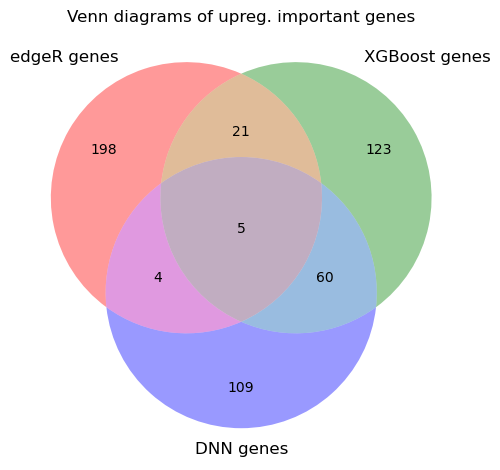

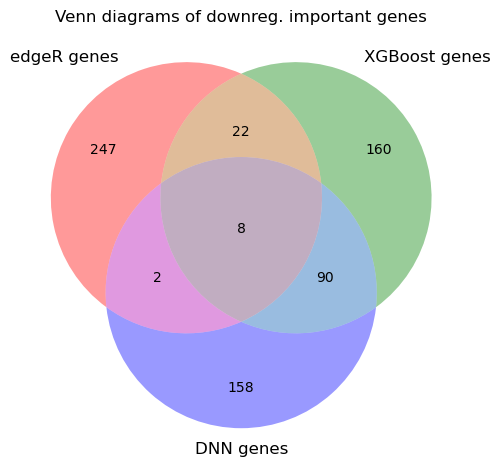

In [53]:
venn3_counts(edger_up_genes, xgboost_up_genes, dnn_up_genes, "Venn diagrams of upreg. important genes", 
                 labels = ("edgeR genes", "XGBoost genes", "DNN genes"))
venn3_counts(edger_down_genes, xgboost_down_genes, dnn_down_genes, "Venn diagrams of downreg. important genes", 
                 labels = ("edgeR genes", "XGBoost genes", "DNN genes"))

In [13]:
print(len(edger_up_genes), len(xgboost_up_genes), len(dnn_up_genes))

228 209 178


In [14]:
print(len(edger_down_genes), len(xgboost_down_genes), len(dnn_down_genes))

279 280 258
